# 04. PyTorch Custom Datasets

https://www.learnpytorch.io/04_pytorch_custom_datasets/

## Table of Contents

- [All Links in Document](#links)
- [PyTorch Custom Datasets](#custom)
- [Loading and Preparing Data](#loadprep)
- [Data Augmentation](#augment)
- [Building a Model](#buildmodel)
- [Evaluation](#eval)
- [Improving a Model](#improve)

## All Links in Document <a name="links" />

- https://pytorch.org/vision/stable/generated/torchvision.datasets.Food101
- https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/
- https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder
- https://pillow.readthedocs.io/en/stable/
- https://pytorch.org/vision/stable/transforms.html
- https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset
- https://realpython.com/python-enumerate/
- https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/
- https://pytorch.org/vision/stable/generated/torchvision.transforms.TrivialAugmentWide
- https://poloclub.github.io/cnn-explainer/
- https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

## PyTorch Custom Datasets <a name="custom" />

In [1]:
# Imports
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy
from torchinfo import summary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from pathlib import Path
from typing import Tuple, Dict, List

In [2]:
print(torch.__version__)

1.13.1+cu117


All the models thus far have been used on pre-existing, prepared datasets or dummy data for testing purposes. However, in real use cases, it's necessary to supply your own dataset, and it's likely that this dataset is not in good shape right away. There are multiple preprocessing steps to undertake to ensure that said data complies with a model's demands. 

<img src="images/04_problem_selection.png" />

What model to use, or what data supply largely depends on the type of problem that needs to be solved. TorchVision was used in the previous chapter for several computer vision examples. Several other domain libraries are: TorchText for text-based problems, TorchAudio for working with audio files, and TorchRec for situations that require recommender systems.

<img src="images/04_problem_space.png" />

Each of these problem spaces has its own domain within PyTorch from where pre-built datasets and functions can be pulled. Each of these domains also contains its own section in the docs. This Notebook will once again focus on TorchVision.

## Loading and Preparing Data <a name="loadprep" />

https://pytorch.org/vision/stable/generated/torchvision.datasets.Food101<br>
https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

An example dataset to use is the Food101 dataset, found in `torchvision.datasets`. This is a dataset containing 101 food categories, with 101,000 images total. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. All images were rescaled to have a maximum side length of 512 pixels.

However, this would be a very broad problem space to start practicing with. To simplify things, a smaller subset of this data will be taken, focusing only on images of pizza, steak, and sushi. This dataset is located in the `PizzaSteakSushi` folder of the data folder. It's first important to inspect the data and see if any flaws need to be rectified.

In [3]:
# Creating helper function to see folder contents
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"{len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [4]:
IMAGE_PATH = Path("data/PizzaSteakSushi")
walk_through_dir(IMAGE_PATH)

2 directories and 0 images in data\PizzaSteakSushi
3 directories and 0 images in data\PizzaSteakSushi\test
0 directories and 25 images in data\PizzaSteakSushi\test\pizza
0 directories and 19 images in data\PizzaSteakSushi\test\steak
0 directories and 31 images in data\PizzaSteakSushi\test\sushi
3 directories and 0 images in data\PizzaSteakSushi\train
0 directories and 78 images in data\PizzaSteakSushi\train\pizza
0 directories and 75 images in data\PizzaSteakSushi\train\steak
0 directories and 72 images in data\PizzaSteakSushi\train\sushi


In total, there are 25 images of pizza, 19 images of steak, and 31 images of sushi in the testing data. In total, there are 78 images of pizza, 75 images of steak, and 72 images of sushi in the training data.

In [5]:
# Setting up training and testing data paths
TRAIN_DIR = Path(f"{IMAGE_PATH}/train")
TEST_DIR = Path(f"{IMAGE_PATH}/test")
TRAIN_DIR, TEST_DIR

(WindowsPath('data/PizzaSteakSushi/train'),
 WindowsPath('data/PizzaSteakSushi/test'))

This is a standard image classification data format, where a separate folder exists for training and testing data. Within each of these, images are split up amongst more folders for each respective class name. Not all data is supplied in the same manner, but this format keeps everything neat and tidy. This format is also used in PyTorch, as seen in the docs of `torchvision.datasets.ImageFolder`.

https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder

In [6]:
# Getting all images using .glob() for the WindowsPath
image_path_list = (list(IMAGE_PATH.glob("*/*/*.jpg")))

In [7]:
image_path_list[:5]

[WindowsPath('data/PizzaSteakSushi/test/pizza/1152100.jpg'),
 WindowsPath('data/PizzaSteakSushi/test/pizza/1503858.jpg'),
 WindowsPath('data/PizzaSteakSushi/test/pizza/1687143.jpg'),
 WindowsPath('data/PizzaSteakSushi/test/pizza/1925494.jpg'),
 WindowsPath('data/PizzaSteakSushi/test/pizza/194643.jpg')]

https://pillow.readthedocs.io/en/stable/

Class: sushi, Dimensions: 408x512


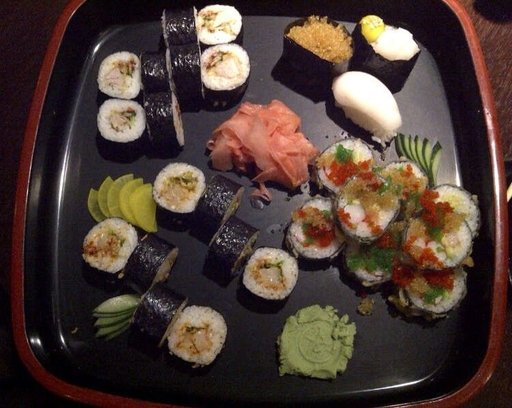

In [8]:
# Opening a random image and visualizing with PIL (PILLOW)
# .stem is the last element in a data path
# .parent is everything but the last element in a data path
random.seed(42)
rnd_img_path = random.choice(image_path_list)
img_class = rnd_img_path.parent.stem
img = Image.open(rnd_img_path)
print(f"Class: {img_class}, Dimensions: {img.height}x{img.width}")
img

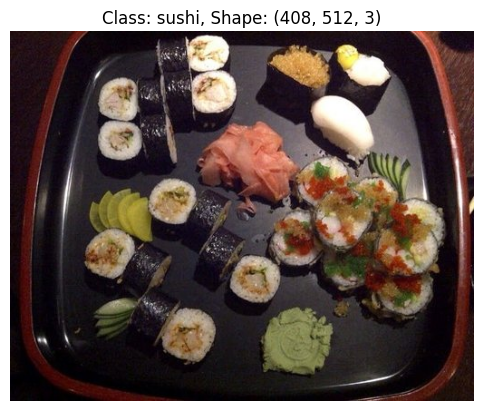

In [9]:
# Visualizing with matplotlib
img_as_array = np.asarray(img)
plt.imshow(img_as_array)
plt.title(f"Class: {img_class}, Shape: {img_as_array.shape}")
plt.axis(False);

The resulting shape from the matplotlib implementation shows the shape's data in the order of height, width, and finally colour channels. This is the Colour Channels Last order (NHWC), which is the default for matplotlin (and PIL). Recall that the default order for PyTorch is Colour Channels First (NCHW).

Before these images can be used with PyTorch, several steps need to be completed first. These are:

- Transform the data into tensors
- Transform the data into `torch.utils.data.Dataset` and subsequently a `torch.utils.DataLoader`

This can be accomplished with `torchvision.datasets` and `torchvision.transforms`. Operations can be chained together using `transforms.Compose`. Both PIL images and numpy arrays are acceptable according to the docs: https://pytorch.org/vision/stable/transforms.html

In [10]:
# Several operations chained together using transforms.Compose
# This transform resizes the images, randomly flips them horizontally (50% chance) and turns them into tensors
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [11]:
# Transform on a single image
data_transform(img)

tensor([[[0.0824, 0.0824, 0.0863,  ..., 0.1412, 0.1373, 0.1294],
         [0.0902, 0.0902, 0.0902,  ..., 0.1412, 0.1373, 0.1255],
         [0.1137, 0.0980, 0.1059,  ..., 0.1333, 0.1412, 0.1294],
         ...,
         [0.1412, 0.1373, 0.1294,  ..., 0.0157, 0.0196, 0.0157],
         [0.1333, 0.1373, 0.1255,  ..., 0.0275, 0.0275, 0.0275],
         [0.1255, 0.1294, 0.1137,  ..., 0.0275, 0.0314, 0.0314]],

        [[0.0431, 0.0431, 0.0392,  ..., 0.0667, 0.0588, 0.0588],
         [0.0353, 0.0431, 0.0392,  ..., 0.0667, 0.0549, 0.0588],
         [0.0392, 0.0471, 0.0471,  ..., 0.0627, 0.0627, 0.0510],
         ...,
         [0.0667, 0.0667, 0.0667,  ..., 0.0078, 0.0078, 0.0039],
         [0.0667, 0.0706, 0.0706,  ..., 0.0118, 0.0118, 0.0118],
         [0.0667, 0.0667, 0.0667,  ..., 0.0196, 0.0157, 0.0118]],

        [[0.0745, 0.0706, 0.0706,  ..., 0.0667, 0.0667, 0.0667],
         [0.0863, 0.0902, 0.0941,  ..., 0.0863, 0.0784, 0.0784],
         [0.1137, 0.1059, 0.0941,  ..., 0.0941, 0.0863, 0.

In [12]:
data_transform(img).shape

torch.Size([3, 64, 64])

In [13]:
# Creating a helper function for the visualization of multiple images
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    if seed:
        random.seed(seed)
    rnd_img_paths = random.sample(image_paths, k=n)
    for path in rnd_img_paths:
        with Image.open(path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)
            
            # Recall that matplotlib expects colour channels last
            # Permute allows for the colour channels to be moved to the end of the tensor
            trns_f = transform(f).permute(1, 2, 0)
            ax[1].imshow(trns_f)
            ax[1].set_title(f"Transformed\nSize: {trns_f.shape}")
            ax[1].axis(False)
            
            fig.suptitle(f"Class: {path.parent.stem}", fontsize=14)

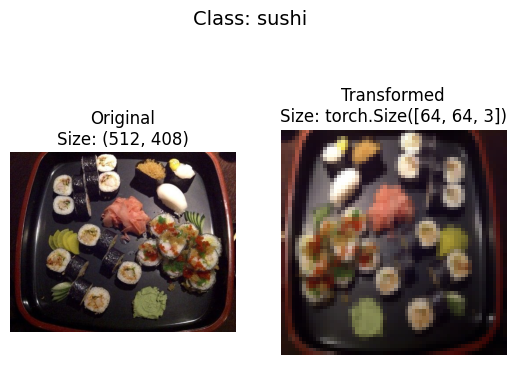

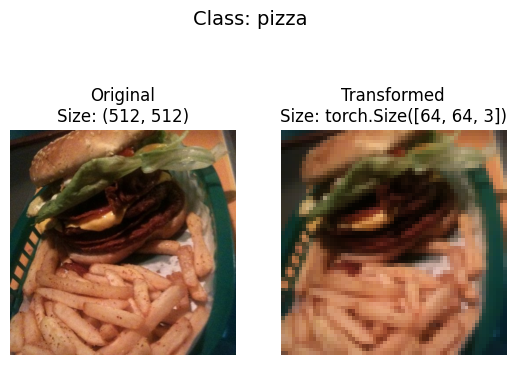

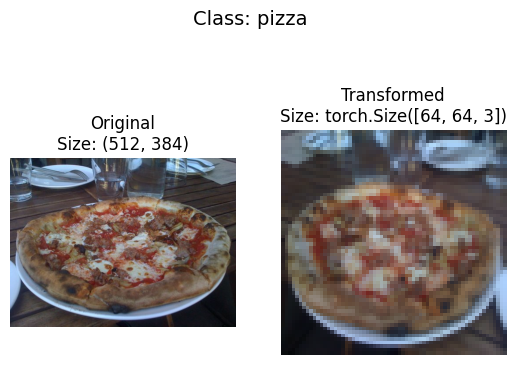

In [14]:
plot_transformed_images(image_path_list, data_transform, 3, 42)

Lower resolution images will improve performance, but more detail and information will be lost. This potentially affects the quality of the neural network's results.

It was previously seen, while loading the images through Windows file paths, that the custom dataset folder structure follows a commonly seen data structure. It was explained that this same format is used in PyTorch as well, as visible in the docs of `torchvision.datasets.ImageFolder`. This same `torchvision.datasets.ImageFolder` can be utilized to load all of the data, as it is one of the built-in functions of `torchvision.datasets` to help with the process of loading data.

In [15]:
# Checking image directory paths again
TRAIN_DIR, TEST_DIR

(WindowsPath('data/PizzaSteakSushi/train'),
 WindowsPath('data/PizzaSteakSushi/test'))

In [16]:
# Loading data using previously created image paths and data transforms
# The target_transform is None by default
train_data = datasets.ImageFolder(root=TRAIN_DIR, transform=data_transform, target_transform=None)
test_data = datasets.ImageFolder(root=TEST_DIR, transform=data_transform, target_transform=None)

In [17]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\PizzaSteakSushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\PizzaSteakSushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

A benefit of using this kind of pre-built dataset loader is that it comes with several attributes that can be inspected.

In [18]:
# Get class names
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [19]:
# Get class names as a dictionary
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [20]:
# Checking out one sample
train_data.samples[0]

('data\\PizzaSteakSushi\\train\\pizza\\1008844.jpg', 0)

With the training and testing data loaded and transformed into proper tensors, it's now possible to use `torch.utils.data.DataLoader` to transform them into Python iterables. This also splits the data up into batches for efficient computing. A more detailed explanation is provided in `03_pytorch_computer_vision.ipynb`.

In [21]:
# The model will never see the test dataset during training, shuffle is not necessary
# Keeping the same order for the test data may make evaluation easier to perform
train_dataloader = DataLoader(dataset=train_data, batch_size=32, num_workers=os.cpu_count(), shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, num_workers=os.cpu_count(), shuffle=False)

The num_workers parameter determines how many CPU cores are used for the loading of the data. To find out how many CPU cores are available, use `os.cpu_count()`. More is usually better & faster!

In [22]:
os.cpu_count()

8

In [23]:
# Checking # of batches in each dataloader
len(train_dataloader), len(test_dataloader)

(8, 3)

Situations may arise where prebuilt functions such as `torchvision.datasets.ImageFolder` don't exist. In that case, it's necessary to build a dataset by replicating the functionality with a custom data loading class. The following steps are necessary to accomplish this:

- Being able to load images from file
- Being able to get class names from the dataset
- Being able to get class names as a dictionary from the dataset

This will allow for a dataset to be created from almost anything due to a lack of reliance on prebuilt PyTorch functions. However, there's no guarantees that it will always work, and the increase in required code will make the process more prone to errors and performance issues. Almost all custom datasets in PyTorch often subclass `torch.utils.data.Dataset`.

https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [24]:
# It's possible to extract the class names from either the training or testing directory
TRAIN_DIR

WindowsPath('data/PizzaSteakSushi/train')

In [25]:
# It's possible to extract the class names using os.scandir
list(os.scandir(TRAIN_DIR))

[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]

In [26]:
# Getting only the class names using a list comprehension
class_names_found = sorted([i.name for i in list(os.scandir(TRAIN_DIR))])
class_names_found

['pizza', 'steak', 'sushi']

In [27]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted([i.name for i in list(os.scandir(directory)) if i.is_dir()])
    
    if not classes:
        raise(f"No classes found in directory: {directory}")
        
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [28]:
find_classes(TRAIN_DIR)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

Extra explanation of enumerate: https://realpython.com/python-enumerate/

Steps to take to replicate `torchvision.datasets.ImageFolder`:

- Subclass `torch.utils.data.Dataset`
- Initialize the subclass with a target directory, as well as a transform if data needs to be transformed
- Create several attributes:
    * paths: The paths of the images
    * transform: The transform to use
    * classes: A list of the target classes
    * class_to_dix: A dictionary of the target classes mapped to integer labels
- Create a function to load images
- Overwrite the `__len__()` method to return length of the dataset
- Overwrite the `__getitem__()` method to return a given sample

The two overwrites are necessary according to the docs of `torch.utils.data.Dataset`, similarly to how it's necessary to overwrite the forward function of neural networks upon class creation.

In [29]:
class ImageFolderCustom(Dataset):
    # Create constructor and class attributes
    def __init__(self, target_dir: str, transform=None):
        self.paths = list(Path(target_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(target_dir)
        
    # Create a function to load images, using PIL
    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # Return number of images, overwriting __len__()
    def __len__(self) -> int:
        return len(self.paths)
    
    # Return a particular sample, overwriting __getitem__()
    # Applies the transform if necessary
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [30]:
# Creating transforms to use with the ImageFolderCustom class
train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [31]:
train_data_custom = ImageFolderCustom(TRAIN_DIR, train_transform)
test_data_custom = ImageFolderCustom(TEST_DIR, test_transform)

In [32]:
# Not as much information is given as with the prebuilt ImageFolder datasets
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x27fff2ef8e0>,
 <__main__.ImageFolderCustom at 0x27fff2efa60>)

In [33]:
len(train_data), len(train_data_custom)

(225, 225)

In [34]:
len(train_data), len(train_data_custom)

(225, 225)

In [35]:
# Class names and class dictionary
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [36]:
# Checking if the custom datasets and the prebuilt ones are the same
print(train_data.classes == train_data_custom.classes)
print(test_data.classes == test_data_custom.classes)

True
True


It's clear that this method allows for the creation of datasets that are indentical to the `torchvision.datasets.ImageFolder` implementation. It's now also possible and necessary to turn these datasets into dataloaders, which is done in the exact same manner as before.

In [37]:
train_dataloader_custom = DataLoader(dataset=train_data_custom, batch_size=32, num_workers=os.cpu_count(), shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom, batch_size=32, num_workers=os.cpu_count(), shuffle=False)

In [38]:
# Checking # of batches in each dataloader
len(train_dataloader_custom), len(test_dataloader_custom)

(8, 3)

## Data Augmentation <a name="augment" />

<img src="images/04_augmentation.png" />

Data augmentation is the process of artifically increasing the diversity of your data. This increases the size of the dataset by creating slightly altered versions of existing images. This is a technique that can be used to create additional data, as well as increasing variation in existing data. In theory, this will make the model more robust when it comes to recognizing desired target classes in unseen data during the testing phase. The image above shows a few examples, but many more options are available as well.

There are many techniques possible to utilize for the improvement of a model. A PyTorch blog post outlines many different functions and techniques that were used to improve a model known as ResNet: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

One such technique featured in the blog post, trivial augment, will be used as an example to perform data augmentation.

https://pytorch.org/vision/stable/generated/torchvision.transforms.TrivialAugmentWide

In [39]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

The `num_magnitude_bins` sets the maximum intensity or magnitude of the alterations. Were it to be set to 5, for example, then the maximum alteration that can occur won't be as severe. The default value is 31.

In [40]:
# Checking num_magnitude_bins value
train_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ToTensor()
)

## Building a Model <a name="buildmodel" />

As the problem space is still about classification, the upcoming neural networks will once again mimic the TinyVGG structure from the CNN Explainer website: https://poloclub.github.io/cnn-explainer/

Code is all manually written again for practice.

In [41]:
# Creating a simple transform without TrivialAugmentWide for now
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [42]:
# Creating data paths
IMAGE_PATH = Path("data/PizzaSteakSushi")
TRAIN_DIR = Path(f"{IMAGE_PATH}/train")
TEST_DIR = Path(f"{IMAGE_PATH}/test")

In [43]:
# Loading datasets
train_data_simple = datasets.ImageFolder(root=TRAIN_DIR, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=TEST_DIR, transform=simple_transform)

In [44]:
# Checking data classes
simple_classes = train_data_simple.classes
simple_classes

['pizza', 'steak', 'sushi']

In [45]:
# Creating dataloaders
train_dataloader_simple = DataLoader(dataset=train_data, batch_size=32, num_workers=os.cpu_count(), shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data, batch_size=32, num_workers=os.cpu_count(), shuffle=False)

In [46]:
# Creating a baseline model
class TinyVGG(nn.Module):
    def __init__(self, in_shape: int, hidden: int, out_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_shape, out_channels=hidden, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # Default stride is the same as the kernel size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden*13*13, out_features=out_shape)
        )
    
    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [47]:
# Creating an instance of the model
model_0 = TinyVGG(in_shape=3, hidden=10, out_shape=len(simple_classes))
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

It's possible to get a neat summary of the model using `torchinfo.summary` to verify that it lines up with the TinyVGG architecture from the CNN Explainer website. The summary also shows how many parameters the model has to deal with at various stages in its workflow.

In [48]:
# Creating a summary of the model
summary(model_0, input_size=[1, 3, 64, 64], device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [49]:
# Loss function, optimizer, and metric
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)
metric_fn = Accuracy(task="multiclass", num_classes=len(simple_classes))

In [50]:
# Saving certain values for later use
train_losses, train_accs = [], []
test_losses, test_accs = [], []

In [51]:
# Functionized training phase
def train_step(model, data_loader, loss_fn, optimizer, metric_fn):
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        y_logits = model(X)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        loss = loss_fn(y_logits, y)
        train_loss += loss
        train_acc += metric_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    print(f"Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.2f}")

In [52]:
# Functionized testing phase
def test_step(model, data_loader, loss_fn, metric_fn):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in data_loader:
            test_logits = model(X)
            test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
            test_loss += loss_fn(test_logits, y)
            test_acc += metric_fn(test_pred, y)
                    
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        print(f"Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}")

In [53]:
torch.manual_seed(42)
epochs = 5
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n--------")
    train_step(model_0, train_dataloader_simple, loss_fn, optimizer, metric_fn)
    test_step(model_0, test_dataloader_simple, loss_fn, metric_fn)

Epoch: 0
--------
Train Loss: 1.10437, Train Acc: 0.41
Test Loss: 1.10790, Test Acc: 0.26
Epoch: 1
--------
Train Loss: 1.07611, Train Acc: 0.43
Test Loss: 1.13528, Test Acc: 0.26
Epoch: 2
--------
Train Loss: 1.07067, Train Acc: 0.43
Test Loss: 1.15792, Test Acc: 0.26
Epoch: 3
--------
Train Loss: 1.10140, Train Acc: 0.30
Test Loss: 1.13980, Test Acc: 0.26
Epoch: 4
--------
Train Loss: 1.05663, Train Acc: 0.53
Test Loss: 1.13356, Test Acc: 0.26


## Evaluation <a name="eval" />

It's visible that the model doesn't perform very well. When this happens, it's important to take a critical look at what the possible causes could be. Loss values and accuracy values have been saved outside the previous functions to visualize as loss curves.

<img src="images/04_loss_curves.png" />

In [54]:
epoch_range = range(epochs)

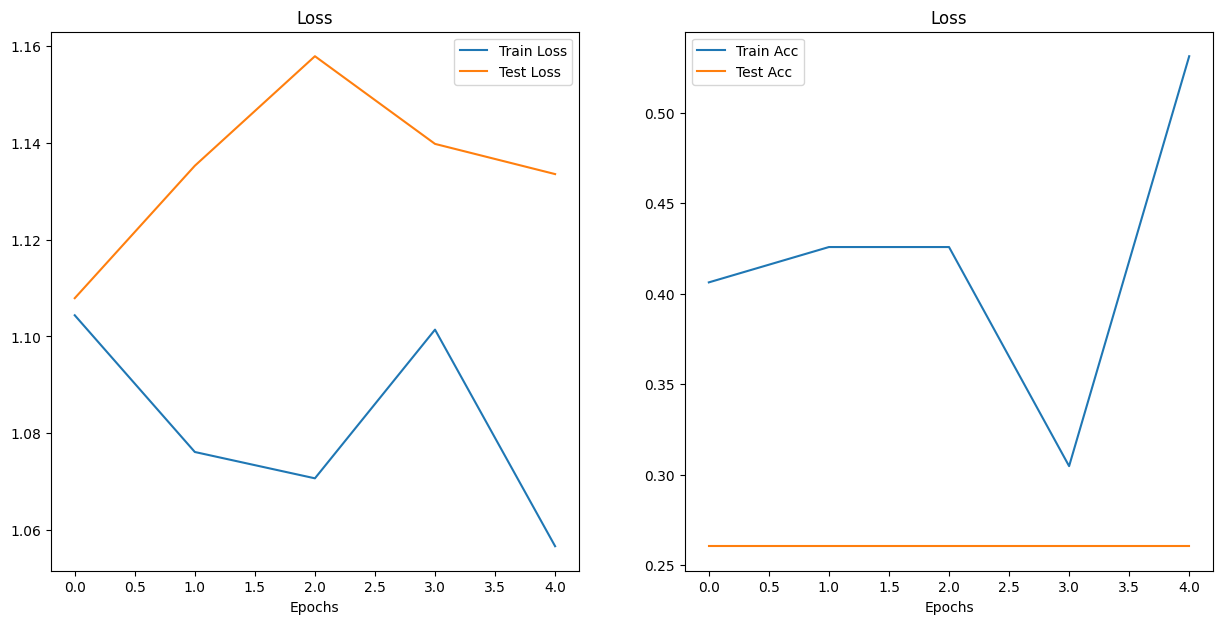

In [55]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, torch.tensor(train_losses), label="Train Loss")
plt.plot(epoch_range, torch.tensor(test_losses), label="Test Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_range, train_accs, label="Train Acc")
plt.plot(epoch_range, test_accs, label="Test Acc")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend();

The loss curves show that the model undergoes a confusing journey. Ideally, loss should decrease over time, and accuracy should increase over time. Being able to interpret these loss curves is a useful skill to identify where issues may lie, but it tends to be difficult to accomplish. Google offers a very educational page that gives more insight on how to interpret these loss curves: https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

In theory, an ideal loss curve has the following appearance:

<img src="images/04_loss_curve_ideal.svg" />

As more steps are taken, or as epoch pass, the loss decreases over time. This represents the model properly understanding the patterns or relationships that are to be found in the data. The result is a model that is able to make the correct choice comfortably and confidently.

An example of a loss curve showing faulty behaviour is as follows:

<img src="images/04_loss_curve_converge.svg" />

In this scenario, the loss curve is not converging (gradually approaching a destination, usually in the direction of 0). It's visible that the loss randomly increases and decreases as steps are taken. Any model results will be of bad quality. When this happens, there are several debugging steps to consider:
- Establishing a baseline and then adjusting the hyperparameters of the model
- Data inspection to discover and discard bad samples (e.g., a picture of pizza in the sushi dataset)
- Lowering the learning rate when the training phase looks this unstable
- Simplifying the dataset to a lower number of samples, then expanding when results are accurate
- Simplifying the model itself, then expanding when results are accurate

Another loss curve example to discuss is when the loss curve appears to behave normally at first, but the values then "explode" near the end of the curve.

<img src="images/04_loss_curve_explode.svg" />

Such a large increase in loss is typically caused by anomalous values in the input data. Possible causes of this issue are:
- NaN values existing in the input data
- Gradients "explode" due to anomalous data
- A division by zero occurs
- A logarithm of zero or negative numbers occurs

It's important to investigate where this anomalous data occurs and to fix the issue when encountered. It's also possible that this type of loss explosion occurs due to the occurrence of outliers in the data. In that scenario, it's important that the outliers are either removed, or evenly distributed between created batches.

It may also occur that chosen metrics are contradictory, as shown here:

<img src="images/04_loss_curve_contradict.svg" />

In this example, it's likely that recall stays stuck at 0 due to the classification of examples never being higher than the threshold for positive classification (a value between 0 and 1). When a value is lower than this threshold, then a negative result is predicted, and vice versa a positive result is predicted. The choice of classification threshold strongly influences the number of false positives and false negatives. This situation often occurs with a large class imbalance. To fix this, it's possible to try the following:
- Lowering the classification treshold
- Check treshold-invariant metrics such as AUC

It could also be the case that the training loss curve is fine, but the testing loss curve is too high.

<img src="images/04_loss_curve_test.svg" />

In this case, the model is likely overfitting on the training data, causing the model's findings to be specialized too much for that specific training data. When the model then meets new (and different) data in the form of the testing dataset, the results will be poor. The following steps can be attempted to remedy this issue:
- Reducing the model capacity
- Introducing regularization
- Checking that the training and testing data are statistically equivalent

It's also possible for the loss curve to become stuck in a repetitive pattern.

<img src="images/04_loss_curve_stuck.svg" />

In this case, the loss curve is showing a repetitive, step-like behaviour. It's likely that the input data seen by the model is exhibiting this repetitive behaviour. For this reason, it's necessary to shuffle your training data before use.

## Improving a Model <a name="improve" />

The loss curves of `model_0` show signs of both overfitting and underfitting. The results of the training loss curve are much better than those of the testing loss curve. However, both of them are mediocre results. Recall that the concept of data augmentation was briefly touched upon, utilizing `transforms.TrivialAugmentWide` to increase data quantity and diversity.

In [56]:
# Creating a transform with TrivialAugmentWide
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [57]:
train_data_aug = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform_trivial)
test_data_aug = datasets.ImageFolder(root=TEST_DIR, transform=test_transform_simple)

In [58]:
train_dataloader_aug = DataLoader(dataset=train_data_aug, batch_size=32, num_workers=os.cpu_count(), shuffle=True)
test_dataloader_aug = DataLoader(dataset=test_data_aug, batch_size=32, num_workers=os.cpu_count(), shuffle=False)

In [59]:
torch.manual_seed(42)
model_1 = TinyVGG(in_shape=3, hidden=10, out_shape=len(simple_classes))
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [60]:
# Loss function, optimizer, and metric
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)
metric_fn = Accuracy(task="multiclass", num_classes=len(simple_classes))

In [61]:
# Saving certain values for later use
train_losses, train_accs = [], []
test_losses, test_accs = [], []

In [62]:
torch.manual_seed(42)
epochs = 5
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n--------")
    train_step(model_1, train_dataloader_aug, loss_fn, optimizer, metric_fn)
    test_step(model_1, test_dataloader_aug, loss_fn, metric_fn)

Epoch: 0
--------
Train Loss: 1.10451, Train Acc: 0.25
Test Loss: 1.10159, Test Acc: 0.26
Epoch: 1
--------
Train Loss: 1.07605, Train Acc: 0.43
Test Loss: 1.13158, Test Acc: 0.26
Epoch: 2
--------
Train Loss: 1.07303, Train Acc: 0.43
Test Loss: 1.17038, Test Acc: 0.26
Epoch: 3
--------
Train Loss: 1.12217, Train Acc: 0.30
Test Loss: 1.15412, Test Acc: 0.26
Epoch: 4
--------
Train Loss: 1.07351, Train Acc: 0.46
Test Loss: 1.14944, Test Acc: 0.30


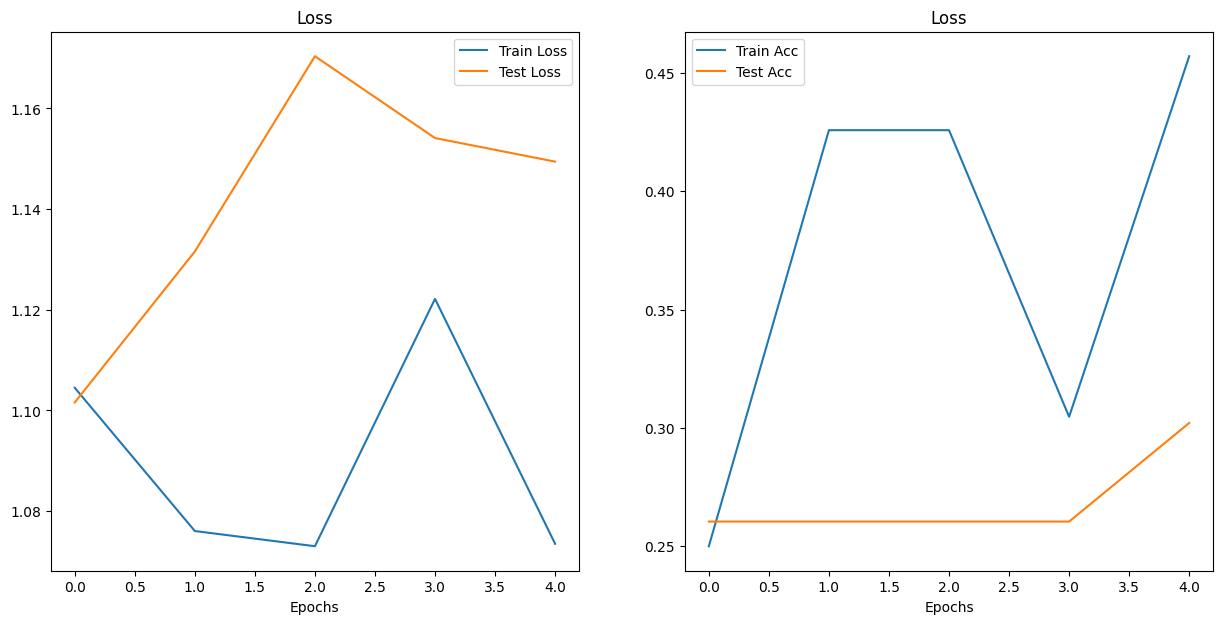

In [63]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, torch.tensor(train_losses), label="Train Loss")
plt.plot(epoch_range, torch.tensor(test_losses), label="Test Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_range, train_accs, label="Train Acc")
plt.plot(epoch_range, test_accs, label="Test Acc")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend();

It's apparent that the introduction of `transforms.TrivialAugmentWide` yielded close to no benefit. The loss curves are still both overfitting and underfitting. This example was to illustrate that issues may not be easily found. It's possible that a more deep-seated issue is at play too, such as the data simply being of poor quality. It's important to explore all the options based on educated decisions such as the exploration of loss curves.